<a href="https://colab.research.google.com/github/SohilaOsama/eicu-code/blob/master/FronciesPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import

In [1]:
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from pickle import dump
from pickle import load

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_1 = pd.read_csv('/content/bone.csv')
df_1.shape

(350, 18)

In [3]:
df_1 = df_1[['Maximum anterior height ', 'Maximum Anterior Breadth', 'Antrosuperior breadth', 'Middle breadth', 'Auricular surface height ',
             'Auricular surface breadth', 'Sacral index', ' S1 Vertebral body mid-diameter', 'Vertebral body width', 
             'Pedicle depth','Pedicle width','Posterior pedicle height','Age','Sex']]
df_1.shape

(350, 14)

In [4]:
df_1.dropna(subset=['Sex'], inplace=True)
df_1.shape

(350, 14)

In [5]:
X = df_1.drop(columns=['Sex'])
print('X :', X.shape)

y = df_1['Sex']
print('y :', y.shape)
print('')

print('y :', np.unique(y, return_counts=True))
print('y :', Counter(y))
print(y.value_counts(normalize=True))

X : (350, 13)
y : (350,)

y : (array([0, 1]), array([160, 190]))
y : Counter({1: 190, 0: 160})
1    0.542857
0    0.457143
Name: Sex, dtype: float64


In [6]:
# ---------- this function is to retain the column names of dataframe after missing values imputation ----------

def impute_fit_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.fit_transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute, to_impute_fit_transform

def impute_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute

In [7]:
# ---------- this function is to retain the column names of dataframe after scaling ----------

def scale_fit_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.fit_transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale, to_scale_fit_transform

def scale_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale

In [9]:
train_accuracy = []
train_recall = []
train_precision = []

validate_accuracy = []
validate_recall = []
validate_precision = []

# ---------- use best parameters and hyperparameters determined in code 4b ----------

decision_boundary = 0.35
oversample = 0.85
reg_alpha = 0

loop_count = 0

for rand_state in [12, 22, 32, 42, 52, 62, 72, 82, 92, 102]:
    
    cross_validate = StratifiedKFold(n_splits=15, shuffle=True, random_state=rand_state)
    
    for train_index, validate_index in cross_validate.split(X, y):
        
        # ---------- get train and validate indices ----------
        
        X_train, X_validate = X.iloc[train_index, :], X.iloc[validate_index, :]
        y_train, y_validate = y.iloc[train_index], y.iloc[validate_index]
        
        loop_count = loop_count + 1
        
        print('---------- random state =', rand_state, ' loop =', loop_count, ' ----------')
        print('')
        print('Before y_train:', Counter(y_train))
        print('Before y_validate:', Counter(y_validate))
        print('')
        
        # ---------- impute on train ----------
        
        knn_impute = KNNImputer(n_neighbors=5)
        X_train_impute, knn_impute_fit_transform = impute_fit_transform(X_train, knn_impute)
        
        # ---------- oversample on train ----------
        
        
        
        # ---------- scale on train ----------
        
        ss = StandardScaler()
        X_train_impute_over_scale, ss_fit_transform = scale_fit_transform(X_train_impute_over, ss)
        
        # ---------- instantiate and fit regularized on train ----------
        
        X_train_impute_over_scale_const = sm.add_constant(X_train_impute_over_scale)
        lr = sm.Logit(y_train_over, X_train_impute_over_scale_const)
        lr_result = lr.fit_regularized(maxiter=500, method='l1', alpha=reg_alpha)
        print('')
        
        # ---------- impute and scale on train ----------
        # ---------- not using oversample to have fair comparison to validate performance ----------
        
        X_train_impute = impute_transform(X_train, knn_impute_fit_transform)
        X_train_impute_scale = scale_transform(X_train_impute, ss_fit_transform)
        
        # ---------- predict and evaluate on train ----------
        
        X_train_impute_scale_const = sm.add_constant(X_train_impute_scale)
        y_train_predicted = (lr_result.predict(X_train_impute_scale_const)>=decision_boundary).astype(int)
        
        train_accuracy.append(accuracy_score(y_train, y_train_predicted))
        train_recall.append(recall_score(y_train, y_train_predicted))
        train_precision.append(precision_score(y_train, y_train_predicted))
        
        # ---------- impute and scale on validate ----------
        
        X_validate_impute = impute_transform(X_validate, knn_impute_fit_transform)
        X_validate_impute_scale = scale_transform(X_validate_impute, ss_fit_transform)
        
        # ---------- predict and evaluate on validate ----------
        
        X_validate_impute_scale_const = sm.add_constant(X_validate_impute_scale)
        y_validate_predicted = (lr_result.predict(X_validate_impute_scale_const)>=decision_boundary).astype(int)
        
        validate_accuracy.append(accuracy_score(y_validate, y_validate_predicted))
        validate_recall.append(recall_score(y_validate, y_validate_predicted))
        validate_precision.append(precision_score(y_validate, y_validate_predicted))
        
    loop_count = 0

---------- random state = 12  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 12  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 12  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 12  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

12  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate:

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

 Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 22  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 22  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 32  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 32  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 32  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 32  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 32  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)



---------- random state = 42  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 42  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 42  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 42  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 42  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 42  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 42  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 52  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 52  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


---------- random state = 52  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 13 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

 ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 52  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 62  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function eval

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 62  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 62  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 62  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 72  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 72  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 72  loop = 15  ----------

Before y_train: Counter({1: 178, 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

82  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 82  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 11  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 82  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 82  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 7  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 10  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 11  ----------

Before y_train: Counter({1: 178, 0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 12  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 14  ----------

Before y_train: Counter({1: 178, 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 92  loop = 15  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 1  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

---------- random state = 102  loop = 2  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 3  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 4  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 5  ----------

Before y_train: Counter({1: 177, 0: 149})
Before y_validate: Counter({1: 13, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 6  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 7  ----------

Before y_train: Counter({1: 177, 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 8  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 9  ----------

Before y_train: Counter({1: 177, 0: 150})
Before y_validate: Counter({1: 13, 0: 10})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 10  ----------

Before y_train: Counter({1: 177

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 13  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 14  ----------

Before y_train: Counter({1: 178, 0: 149})
Before y_validate: Counter({1: 12, 0: 11})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76

---------- random state = 102  loop = 15  ----------

Before y_train: Counter({1: 17

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future versi

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5963453037874928
            Iterations: 76
            Function evaluations: 76
            Gradient evaluations: 76



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
temp_df = zip(train_accuracy, validate_accuracy)
temp_df = pd.DataFrame(temp_df, columns=['train_accuracy', 'validate_accuracy'])
temp_df['overfit_%'] = (temp_df['validate_accuracy']-temp_df['train_accuracy'])/temp_df['train_accuracy']*100
temp_df

,train_accuracy,validate_accuracy,overfit_%
0,0.665644,0.625000,-6.105991
1,0.662577,0.666667,0.617284
2,0.662577,0.666667,0.617284
3,0.653374,0.791667,21.165884
4,0.659509,0.708333,7.403101
...,...,...,...
145,0.660550,0.695652,5.314010
146,0.660550,0.695652,5.314010
147,0.669725,0.565217,-15.604527
148,0.657492,0.739130,12.416582


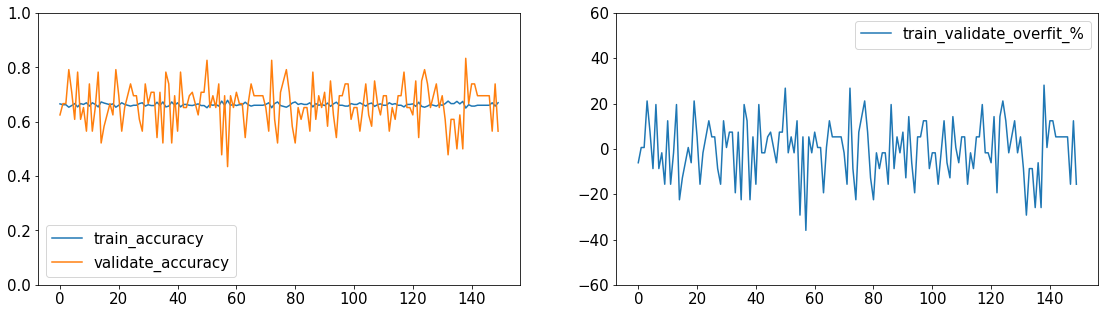

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_accuracy'], label='train_accuracy')
ax[0].plot(temp_df['validate_accuracy'], label='validate_accuracy')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

In [12]:
temp_df = zip(train_recall, validate_recall)
temp_df = pd.DataFrame(temp_df, columns=['train_recall', 'validate_recall'])
temp_df['overfit_%'] = (temp_df['validate_recall']-temp_df['train_recall'])/temp_df['train_recall']*100
temp_df

,train_recall,validate_recall,overfit_%
0,0.903955,0.846154,-6.394231
1,0.898305,0.923077,2.757620
2,0.892655,1.000000,12.025316
3,0.892655,1.000000,12.025316
4,0.903955,0.846154,-6.394231
...,...,...,...
145,0.910112,0.750000,-17.592593
146,0.893258,1.000000,11.949686
147,0.898876,0.916667,1.979167
148,0.893258,1.000000,11.949686


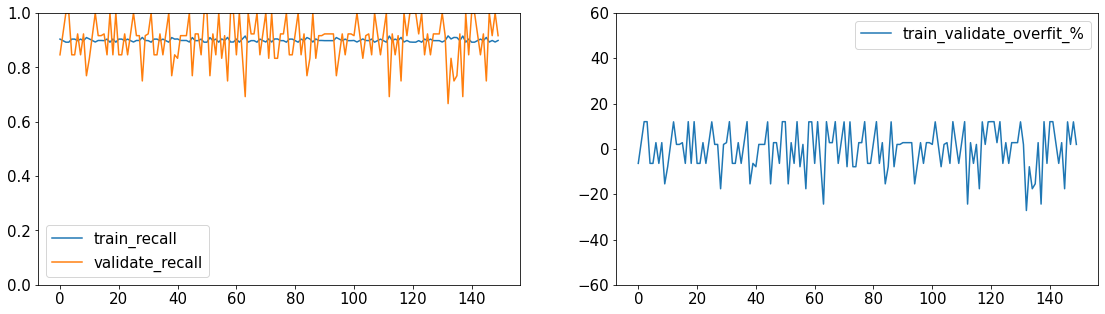

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_recall'], label='train_recall')
ax[0].plot(temp_df['validate_recall'], label='validate_recall')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

In [14]:
temp_df = zip(train_precision, validate_precision)
temp_df = pd.DataFrame(temp_df, columns=['train_precision', 'validate_precision'])
temp_df['overfit_%'] = (temp_df['validate_precision']-temp_df['train_precision'])/temp_df['train_precision']*100
temp_df

,train_precision,validate_precision,overfit_%
0,0.634921,0.611111,-3.750000
1,0.633466,0.631579,-0.297915
2,0.634538,0.619048,-2.441230
3,0.626984,0.722222,15.189873
4,0.629921,0.687500,9.140625
...,...,...,...
145,0.630350,0.692308,9.829060
146,0.633466,0.631579,-0.297915
147,0.640000,0.550000,-14.062500
148,0.630952,0.666667,5.660377


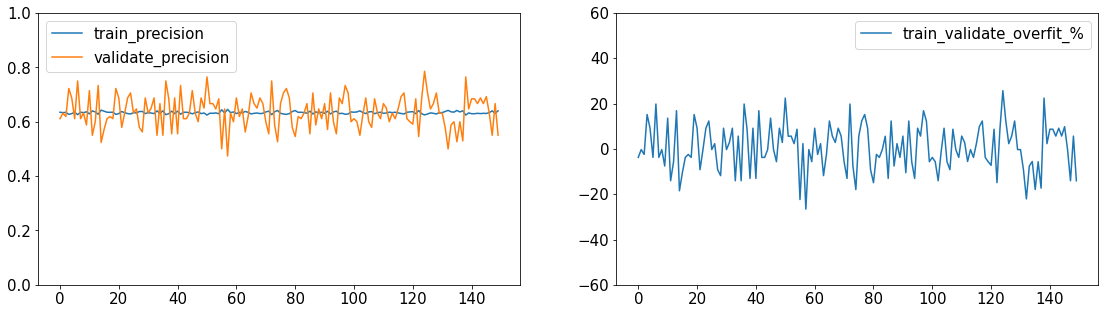

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

ax[0].plot(temp_df['train_precision'], label='train_precision')
ax[0].plot(temp_df['validate_precision'], label='validate_precision')
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(fontsize=15)

ax[1].plot(temp_df['overfit_%'], label='train_validate_overfit_%')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_ylim([-60, 60])
ax[1].legend(fontsize=15)

In [16]:
# ---------- impute ----------

knn_impute = KNNImputer(n_neighbors=5)
X_impute, knn_impute_fit_transform = impute_fit_transform(X, knn_impute)

# ---------- oversample ----------

o_s = SMOTE(random_state=42, sampling_strategy=oversample)
X_impute_over, y_over = o_s.fit_resample(X_impute, y.ravel())

# ---------- scale ----------

ss = StandardScaler()
X_impute_over_scale, ss_fit_transform = scale_fit_transform(X_impute_over, ss)

# ---------- instantiate and fit regularized ----------

X_impute_over_scale_const = sm.add_constant(X_impute_over_scale)
lr = sm.Logit(y_over, X_impute_over_scale_const)
lr_result = lr.fit_regularized(maxiter=500, method='l1', alpha=reg_alpha)

# ---------- model summary ----------

print('-------------------- Model Summary 1: From Statsmodels API --------------------')
print('')
print(lr_result.summary())
print('')

print('-------------------- Model Summary 2: Sorted by ascending p --------------------')
print('')
temp_df = pd.read_html(lr_result.summary().tables[1].as_html(), header=0, index_col=0)[0]
temp_df = pd.DataFrame(temp_df)
temp_df.reset_index(level=0, inplace=True)
temp_df.rename(columns={'index': 'feature', 'std err': 'std_err', 'P>|z|': 'p', 'coef': 'std_coef'}, inplace=True)
temp_df = temp_df[['feature', 'std_coef', 'z', 'p']]
temp_df.sort_values(by='p', ascending=True, inplace=True)
print(temp_df)
print('')

print('-------------------- Model Summary 3: p < 0.05 sorted by coef --------------------')
print('')
print(temp_df[temp_df['p']<0.05][['feature', 'std_coef', 'z', 'p']].sort_values(by='std_coef'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5901460343917106
            Iterations: 84
            Function evaluations: 84
            Gradient evaluations: 84
-------------------- Model Summary 1: From Statsmodels API --------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  351
Model:                          Logit   Df Residuals:                      337
Method:                           MLE   Df Model:                           13
Date:                Thu, 07 Jul 2022   Pseudo R-squ.:                  0.1444
Time:                        00:13:07   Log-Likelihood:                -207.14
converged:                       True   LL-Null:                       -242.10
Covariance Type:            nonrobust   LLR p-value:                 8.346e-10
                                      coef    std err          z      P>|z| 

In [17]:
#dump(knn_impute_fit_transform, open('impute_fit_transform.pkl', 'wb'))
dump(ss_fit_transform, open('scale_fit_transform.pkl', 'wb'))
dump(lr_result, open('model_RF.pkl', 'wb'))

In [18]:
RF_model = load(open('model_RF.pkl', 'rb'))
#lrr_impute = load(open('impute_fit_transform.pkl', 'rb'))
RF_scale = load(open('scale_fit_transform.pkl', 'rb'))

In [19]:
print(RF_model.params)

const                              0.242027
Maximum anterior height            0.972066
Maximum Anterior Breadth          -0.736053
Antrosuperior breadth             -1.740085
Middle breadth                    -0.532267
Auricular surface height           0.106362
Auricular surface breadth          0.075289
Sacral index                       0.724731
 S1 Vertebral body mid-diameter    0.978796
Vertebral body width               0.403441
Pedicle depth                      0.578232
Pedicle width                      0.298553
Posterior pedicle height           0.016928
Age                               -0.059928
dtype: float64


In [20]:
print(RF_model.params.values[0])

0.24202669170476754


In [21]:
X_given = pd.DataFrame(columns=RF_model.params.index)

In [22]:
X_train_impute = impute_transform(X_train, knn_impute_fit_transform)
X_train_impute_scale = scale_transform(X_train_impute, ss_fit_transform)

In [28]:
print(X_given)

      const Maximum anterior height  Maximum Anterior Breadth  \
0  0.242027                      NaN                     12.5   

  Antrosuperior breadth Middle breadth Auricular surface height   \
0                  11.6            9.4                       NaN   

  Auricular surface breadth Sacral index  S1 Vertebral body mid-diameter  \
0                       8.5        116.8                             NaN   

  Vertebral body width Pedicle depth Pedicle width Posterior pedicle height  \
0                    3           9.3           3.9                     1.29   

  Age  Maximum anterior height  Auricular surface height  \
0  55                     10.7                       5.2   

   S1 Vertebral body mid-diameter  
0                             5.0  
